## Data fields & description:
- Project Number: the unique project id
- Project Title: the project name (Mandatory)
- Project Title English: the project name in English (Optional)
- Reponsible Applicant: the person who submitted the research proposal to the SNSF (Mandatory)
- Funding Instrument: funding schemes for research and scientific communication
- Funding Instrument Hierarchy: top level hierarchy funding instrument
- Institution: the research institution where the project will largely be carried out
- University: the University where the project will largely be carried out. **This field is only filled if the research is carried out at a Swiss institution, otherwise the field remains blank. In the case of mobility fellowships, it is generally left empty.**
- Discipline Number: number of the discipline
- Discipline Name: name of the discipline
- Discipline Name Hierarchy: top level of discipline
- Start Date: the starting date of the project
- End Date: the actual end date of the project
- Approved Amount: the total approved money spent for the project. **This amount is not indicated in the case of mobility fellowships.**
- Keywords: unstructured field.

In [1]:
# import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
import folium
import requests
import re
%matplotlib inline

In [2]:
# Define constants
GEONAMES_SEARCH_URL = 'http://api.geonames.org/searchJSON'
GOOGLE_SEARCH_URL = 'https://maps.googleapis.com/maps/api/place/textsearch/json'
GOOGLE_GEOCODE_URL = 'https://maps.googleapis.com/maps/api/geocode/json'

In [3]:
# load the p3
df = pd.read_csv('./data/P3_GrantExport.csv', sep=";")

The documentation of fields mentions that institutes from outside Switzerland don't have an entry in University. So it's safe to throw away all rows has 'nicht zuteilbar - NA' in university column.

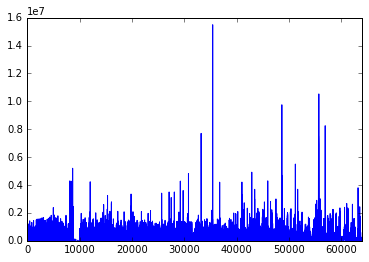

In [4]:
df = df[df['Approved Amount'] != 'data not included in P3']
df['Approved Amount'] = df['Approved Amount'].astype(float)
df['Approved Amount'].plot()

- 'Nicht zuteilbar - NA' : not assignable

So we remove this field!

In [5]:
df_Nicht = df[df['University'] == 'Nicht zuteilbar - NA']
df = df[df['University'] != 'Nicht zuteilbar - NA']

In [6]:
df_null = df[df['University'].isnull()]
df = df[df['University'].notnull()]

In [7]:
universities = list(df['University'].unique())
for university in universities:
    if ' - ' not in university:
        df.loc[df['University'] == university,'University'] = university[::-1].replace(" "," - ",1)[::-1]
universities = list(df['University'].unique())

## GeoNames Search Webservice:
GeoNames api offers services in XML and JSON format. We use JSON format as it is easier to extract data from it.

In [8]:
def search(url, params):
    """ This function returns a json file containing the geographical results from the
    Geonames or google map websites """
    try:
        response = requests.get(url, params)
    except:
        raise ServiceException(url, params)
    return response.json()

In [9]:
lst = []
for university in universities:
    params = {'q': university, 'maxRows': 1, 'country': 'CH', 'username': 'sorooshafiee'}
    response = search(GEONAMES_SEARCH_URL, params)
    lst.append(response['totalResultsCount'])
print('Number of the recovered contons from the university name: {}/{}'.format(sum(x != 0 for x in lst), len(lst)))

Number of the recovered contons from the university name: 5/76


## Google API


In [10]:
def get_geonames(url, params, types):
    """ This function returns the filtered address component """
    try:
        response = requests.get(url,params)
    except:
        raise ServiceException(url, params)
    address_comps = response.json()['results'][0]['address_components']
    filter_method = lambda x: len(set(x['types']).intersection(list(types)))
    return filter(filter_method, address_comps)

In [21]:
with open('data/api_key.txt', 'r') as in_file:
    api_key = in_file.read()

In [13]:
match = {}
response = {}
unmatch = []
types = ['administrative_area_level_1']
for university in universities:
    params = {'key' : api_key, 'query' : university}
    response[university] = search(GOOGLE_SEARCH_URL, params)
    if response[university]['status'] == 'OK':
        location = response[university]['results'][0]['geometry']['location']
        latlng = str(round(location['lat'],2)) + ',' + str(round(location['lng'],2))
        params = {'latlng': latlng}
        address_comps = get_geonames(GOOGLE_GEOCODE_URL, params, types)
        canton = list(address_comps)[0]['long_name']
        match.update({university: canton})
    else:   
        unmatch.append(university)
print('Number of the recovered contons from the university name: {}/{}'.format(len(match), len(universities)))

Number of the recovered contons from the university name: 59/76


In [27]:
new_match = []
for university in unmatch:
    print(university)
    sub_str = re.search(r'(.+?) \-\ (\w+)', university).group(1)
    if '(' in sub_str:
        sub_str = re.search(r'(.+?) \((.+?)\)', sub_str).group(1)
    params = {'key' : api_key, 'query' : sub_str}
    response[university] = search(GOOGLE_SEARCH_URL, params)
    if response[university]['status'] == 'OK':
        location = response[university]['results'][0]['geometry']['location']
        latlng = str(round(location['lat'],2)) + ',' + str(round(location['lng'],2))
        params = {'latlng': latlng}
        address_comps = get_geonames(GOOGLE_GEOCODE_URL, params, types)
        canton = list(address_comps)[0]['long_name']
        match.update({university: canton})
        new_match.append(university)
unmatch = [university for university in unmatch if university not in new_match]
print('Number of the recovered contons from the university name: {}/{}'.format(len(match), len(universities)))

Number of the recovered contons from the university name: 65/76


In [56]:
new_match = []
for university in unmatch:
    sub_str = re.search(r'(.+?) \-\ (\w+)', university).group(1)
    if '(' in sub_str:
        sub_str = re.search(r'(.+?) \((.+?)\)', sub_str).group(1)
    if '.' in sub_str:
        if sub_str.endswith('.'):
            sub_str = re.search(r'(.+?) (\w+)\.', sub_str).group(1)
        else:
            sub_str = sub_str[sub_str.rfind('.')+2::]
    params = {'key' : api_key, 'query' : sub_str}
    response[university] = search(GOOGLE_SEARCH_URL, params)
    if response[university]['status'] == 'OK':
        location = response[university]['results'][0]['geometry']['location']
        latlng = str(round(location['lat'],2)) + ',' + str(round(location['lng'],2))
        params = {'latlng': latlng}
        address_comps = get_geonames(GOOGLE_GEOCODE_URL, params, types)
        canton = list(address_comps)[0]['long_name']
        match.update({university: canton})
        new_match.append(university)
unmatch = [university for university in unmatch if university not in new_match]
print('Number of the recovered contons from the university name: {}/{}'.format(len(match), len(universities)))

Number of the recovered contons from the university name: 69/76


In [70]:
# Add the rest manually
manual_match = {
    'Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL': 'Zürich',   
    'Forschungsanstalten Agroscope - AGS': 'Zürich',
    'Schweizer Kompetenzzentrum Sozialwissensch. - FORS': 'Vaud'
}

The following items in university field should be searched through the institution filed as it is not clear where they are located.
- 'NPO (Biblioth., Museen, Verwalt.) - NPO': for libraries, museums, administrations
- 'Firmen/Privatwirtschaft - FP': companies/private sectors
- 'Weitere Spitäler - ASPIT': other hospitals
- 'Weitere Institute - FINST': other institutes

In [ ]:
lst

In [ ]:
m = re.search('(?<=-)\w+', 'Staatsunabh. Theologische Hochschule Basel - STHB').group(0)


In [ ]:
m.group(0)

In [ ]:
m = re.sub(r'(.+?)\.\ (.+?) \-\ (\w+)', 'Theologische. Hochschule Basel - STHB')

In [ ]:
match = re.search(r'(\w+), (\w+): (\S+)', 'Doe, John: 555-1212')

In [ ]:
match.group(3)

In [ ]:
df.loc[df['University'] == 'Forschungskommission SAGW','University'] = 'Forschungskommission - SAGW'

In [ ]:
df[df['University'] == 'Forschungskommission - SAGW']

In [ ]:
len(universities)

In [ ]:
response

In [ ]:
m = re.search(r'(.+?) \-\ (\w+)', university)

In [ ]:
sub_str = re.search(r'(.+?) \-\ (\w+)', university).group(1)

In [ ]:
sub_str2 = re.search(r'(.+?) \((.+?)\)', university).group(1)

In [ ]:
sub_str2

In [ ]:
university

In [ ]:
for university in universities:
    sub_str = re.search(r'(.+?) \-\ (\w+)', university).group(1)
    if '(' in sub_str:
        sub_str = re.search(r'(.+?) \((.+?)\)', sub_str).group(1)
    print(sub_str)

In [ ]:
a = {1: 2}

In [ ]:
a[1] = 3

In [ ]:
a